# About this Dataset

Context
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

The original MNIST dataset contains a lot of handwritten digits. Members of the AI/ML/Data Science community love this dataset and use it as a benchmark to validate their algorithms. In fact, MNIST is often the first dataset researchers try. "If it doesn't work on MNIST, it won't work at all", they said. "Well, if it does work on MNIST, it may still fail on others."

Zalando seeks to replace the original MNIST dataset

Content
Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

To locate a pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27. The pixel is located on row i and column j of a 28 x 28 matrix.
For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below. 

Labels

Each training and test example is assigned to one of the following labels:

0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot 

TL;DR

Each row is a separate image
Column 1 is the class label.
Remaining columns are pixel numbers (784 total).
Each value is the darkness of the pixel (1 to 255)

https://www.kaggle.com/zalando-research/fashionmnist

Unzip fashion-mnist_test.csv.zip and fashion-mnist_train.csv.zip before proceeding

# Setup

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from sklearn.model_selection import train_test_split

img_rows, img_cols = 28, 28

# to make this notebook's output stable across runs
def reset_graph(seed=36):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Preprocessing

In [2]:
data_train = pd.read_csv('fashion-mnist_train.csv')
data_test = pd.read_csv('fashion-mnist_test.csv')

X = np.array(data_train.iloc[:, 1:])
y = np.array(data_train.iloc[:, 0])

# train validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=12)

# test data
X_test = np.array(data_test.iloc[:, 1:])
y_test = np.array(data_test.iloc[:, 0])

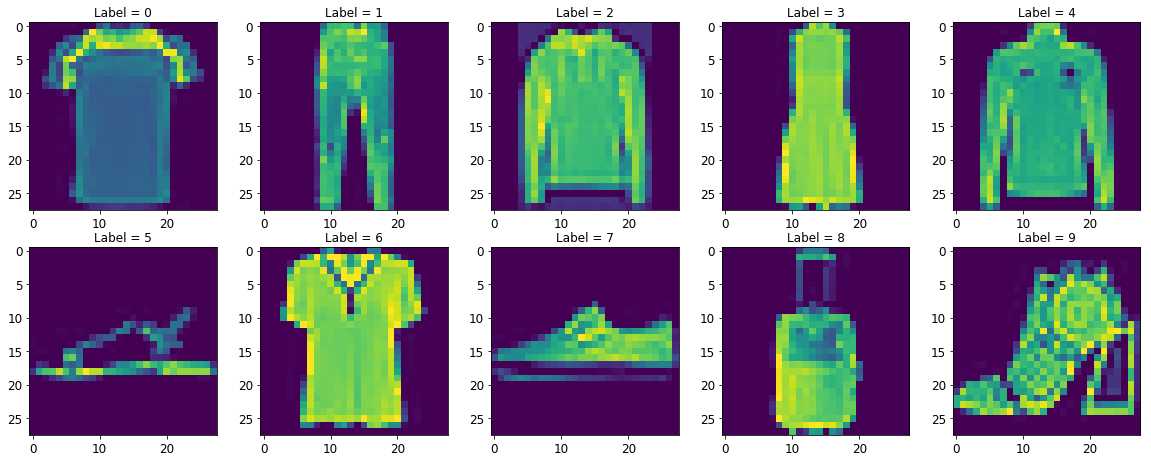

In [3]:
# plot some images
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.title('Label = %d'%i)
    first_index = np.argmax(y_train==i)
    plt.imshow(X_train[first_index].reshape(img_rows, img_cols))

In [4]:
X_train = X_train.astype("float") / 255
X_valid = X_valid.astype("float") / 255
X_test = X_test.astype("float") / 255

In [5]:
y_train = y_train.astype("int")
y_valid = y_valid.astype("int")
y_test = y_test.astype("int")

In [6]:
print('X_train.shape =', X_train.shape)
print('y_train.shape =', y_train.shape)

X_train.shape = (48000, 784)
y_train.shape = (48000,)


# Simple ANN

In [7]:
n_inputs = img_rows*img_cols
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

construct graph

In [8]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y") 

In [9]:
with tf.name_scope("ann"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [10]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    loss_summary = tf.summary.scalar('log_loss', loss)

In [11]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [12]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    accuracy_summary = tf.summary.scalar('accuracy', accuracy)

In [13]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

define the directory to write the TensorBoard logs to

In [14]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [15]:
logdir = log_dir("ann")

In [16]:
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

execute graph

In [17]:
m, n = X_train.shape

In [18]:
n_epochs = 50
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "./ann/ann_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./ann/ann_model"

best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = 50

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for iteration in range(X_train.shape[0] // batch_size):
            X_batch = X_train[iteration*batch_size:(iteration+1)*batch_size-1,]
            y_batch = y_train[iteration*batch_size:(iteration+1)*batch_size-1,]            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val, loss_val, accuracy_summary_str, loss_summary_str = sess.run([accuracy, loss, accuracy_summary, loss_summary], feed_dict={X: X_valid, y: y_valid})
        file_writer.add_summary(accuracy_summary_str, epoch)
        file_writer.add_summary(loss_summary_str, epoch)
        if epoch % 5 == 0:
            print("Epoch:", epoch,
                  "\tValidation accuracy: {:.3f}%".format(accuracy_val * 100),
                  "\tLoss: {:.5f}".format(loss_val))
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
            if loss_val < best_loss:
                saver.save(sess, final_model_path)
                best_loss = loss_val
            else:
                epochs_without_progress += 5
                if epochs_without_progress > max_epochs_without_progress:
                    print("Early stopping")
                    break

Epoch: 0 	Validation accuracy: 79.975% 	Loss: 0.59160
Epoch: 5 	Validation accuracy: 84.858% 	Loss: 0.43088
Epoch: 10 	Validation accuracy: 86.050% 	Loss: 0.39560
Epoch: 15 	Validation accuracy: 86.767% 	Loss: 0.37514
Epoch: 20 	Validation accuracy: 87.092% 	Loss: 0.36127
Epoch: 25 	Validation accuracy: 87.400% 	Loss: 0.35145
Epoch: 30 	Validation accuracy: 87.583% 	Loss: 0.34508
Epoch: 35 	Validation accuracy: 87.800% 	Loss: 0.33969
Epoch: 40 	Validation accuracy: 87.967% 	Loss: 0.33621
Epoch: 45 	Validation accuracy: 88.158% 	Loss: 0.33377


In [19]:
os.remove(checkpoint_epoch_path)

In [20]:
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    accuracy_val = accuracy.eval(feed_dict={X: X_test, y: y_test})

INFO:tensorflow:Restoring parameters from ./ann/ann_model


In [21]:
accuracy_val

0.88940001

To run tensorboard:tensorboard --logdir=tf_logs/ --host=127.0.0.1
There is an issue with Chrome and the graph is not displayed properly
Use Edge or Firefox instead

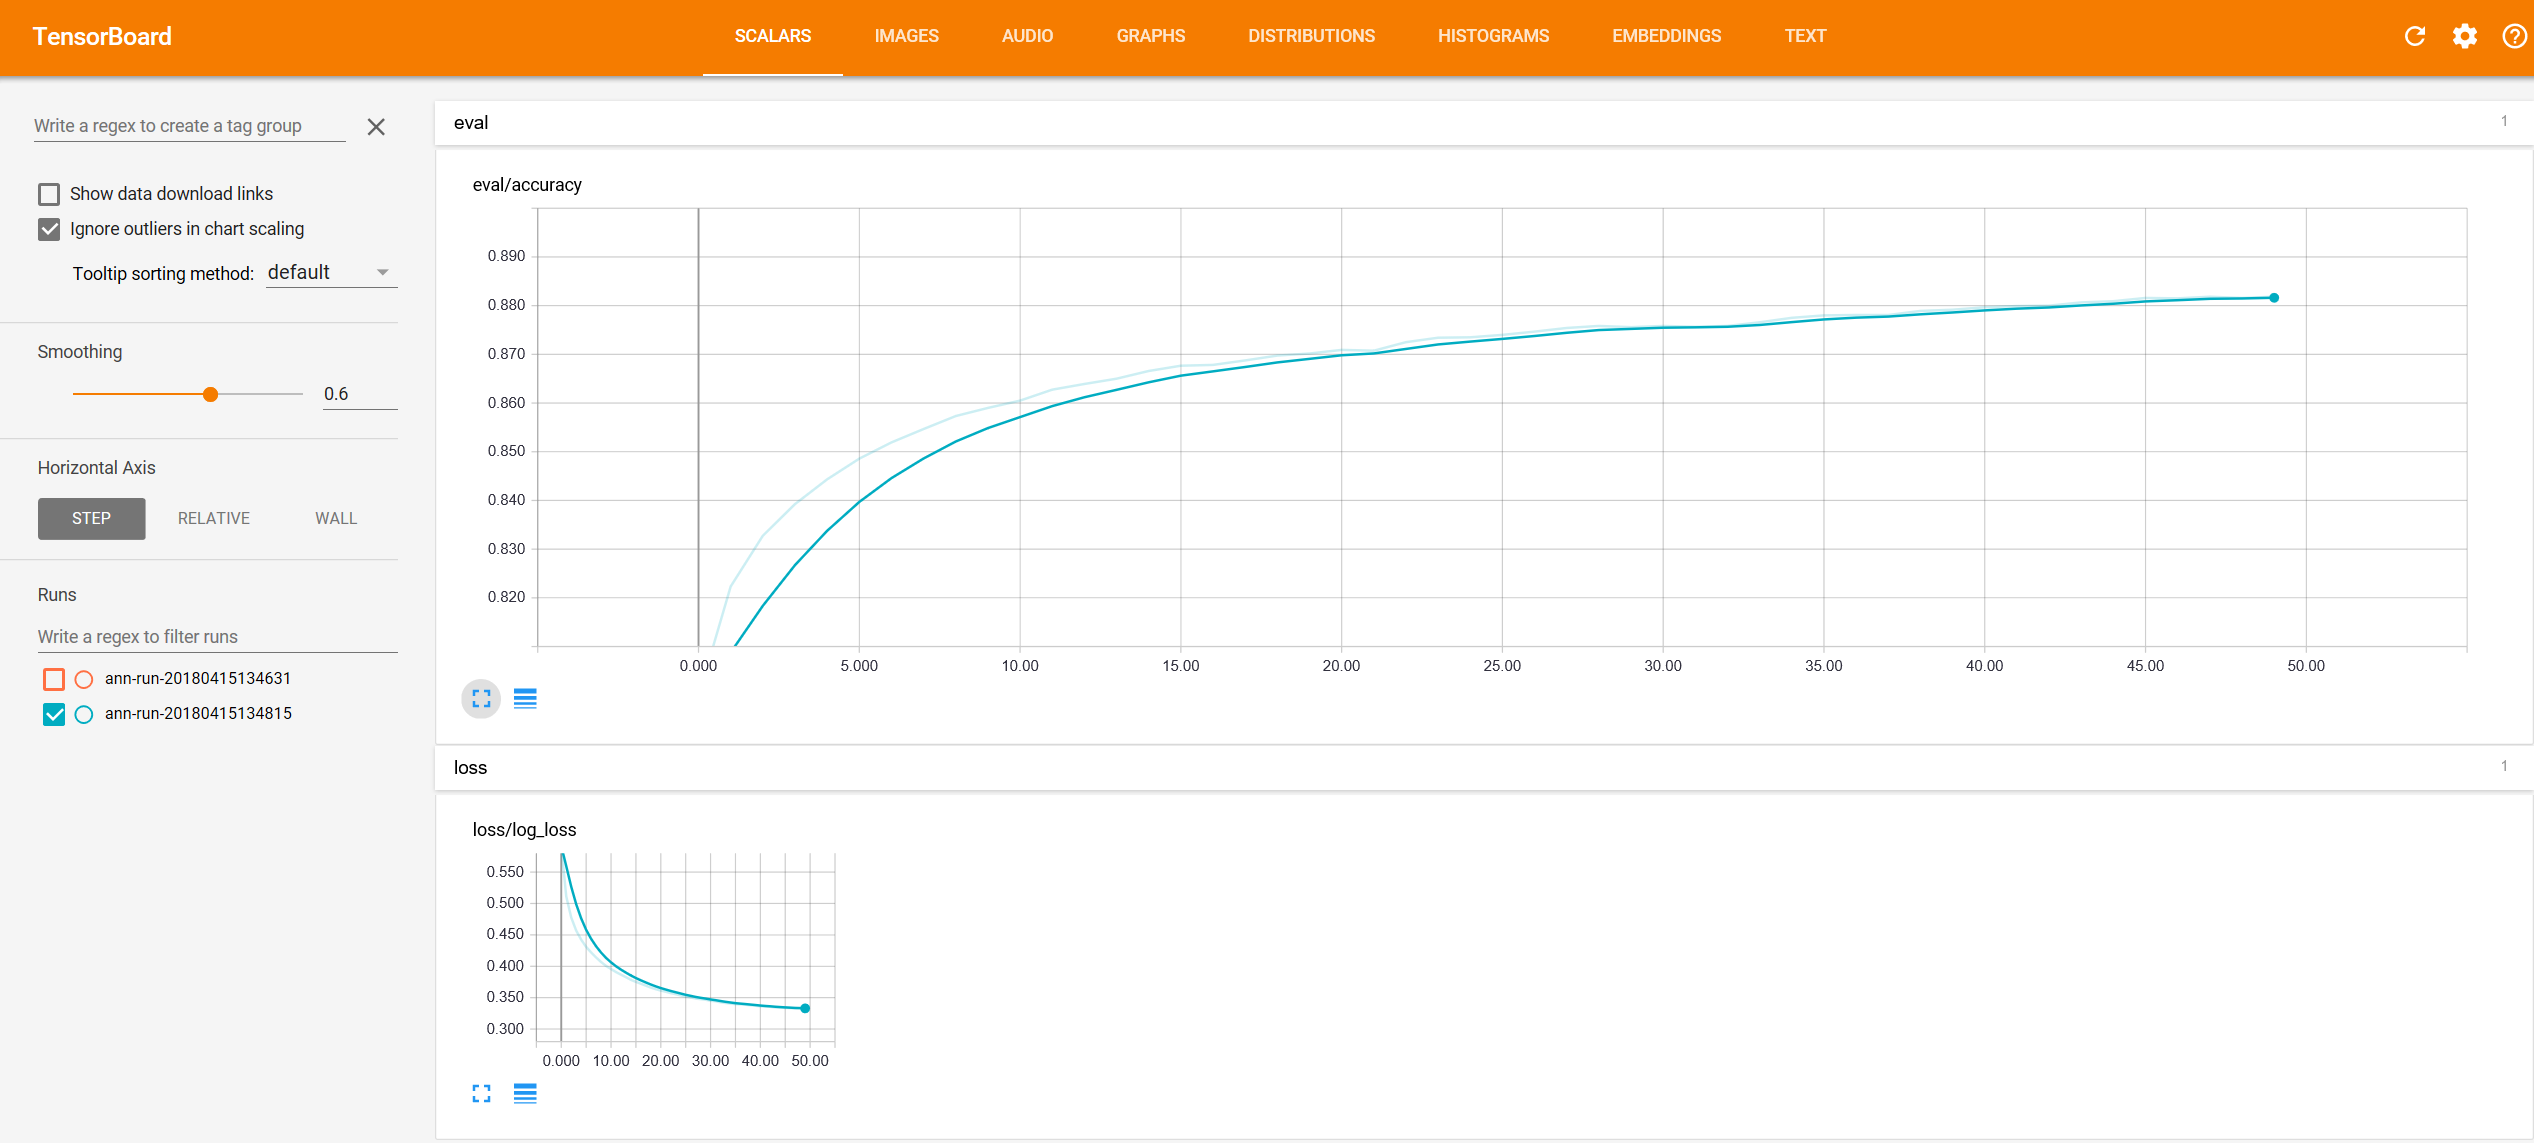

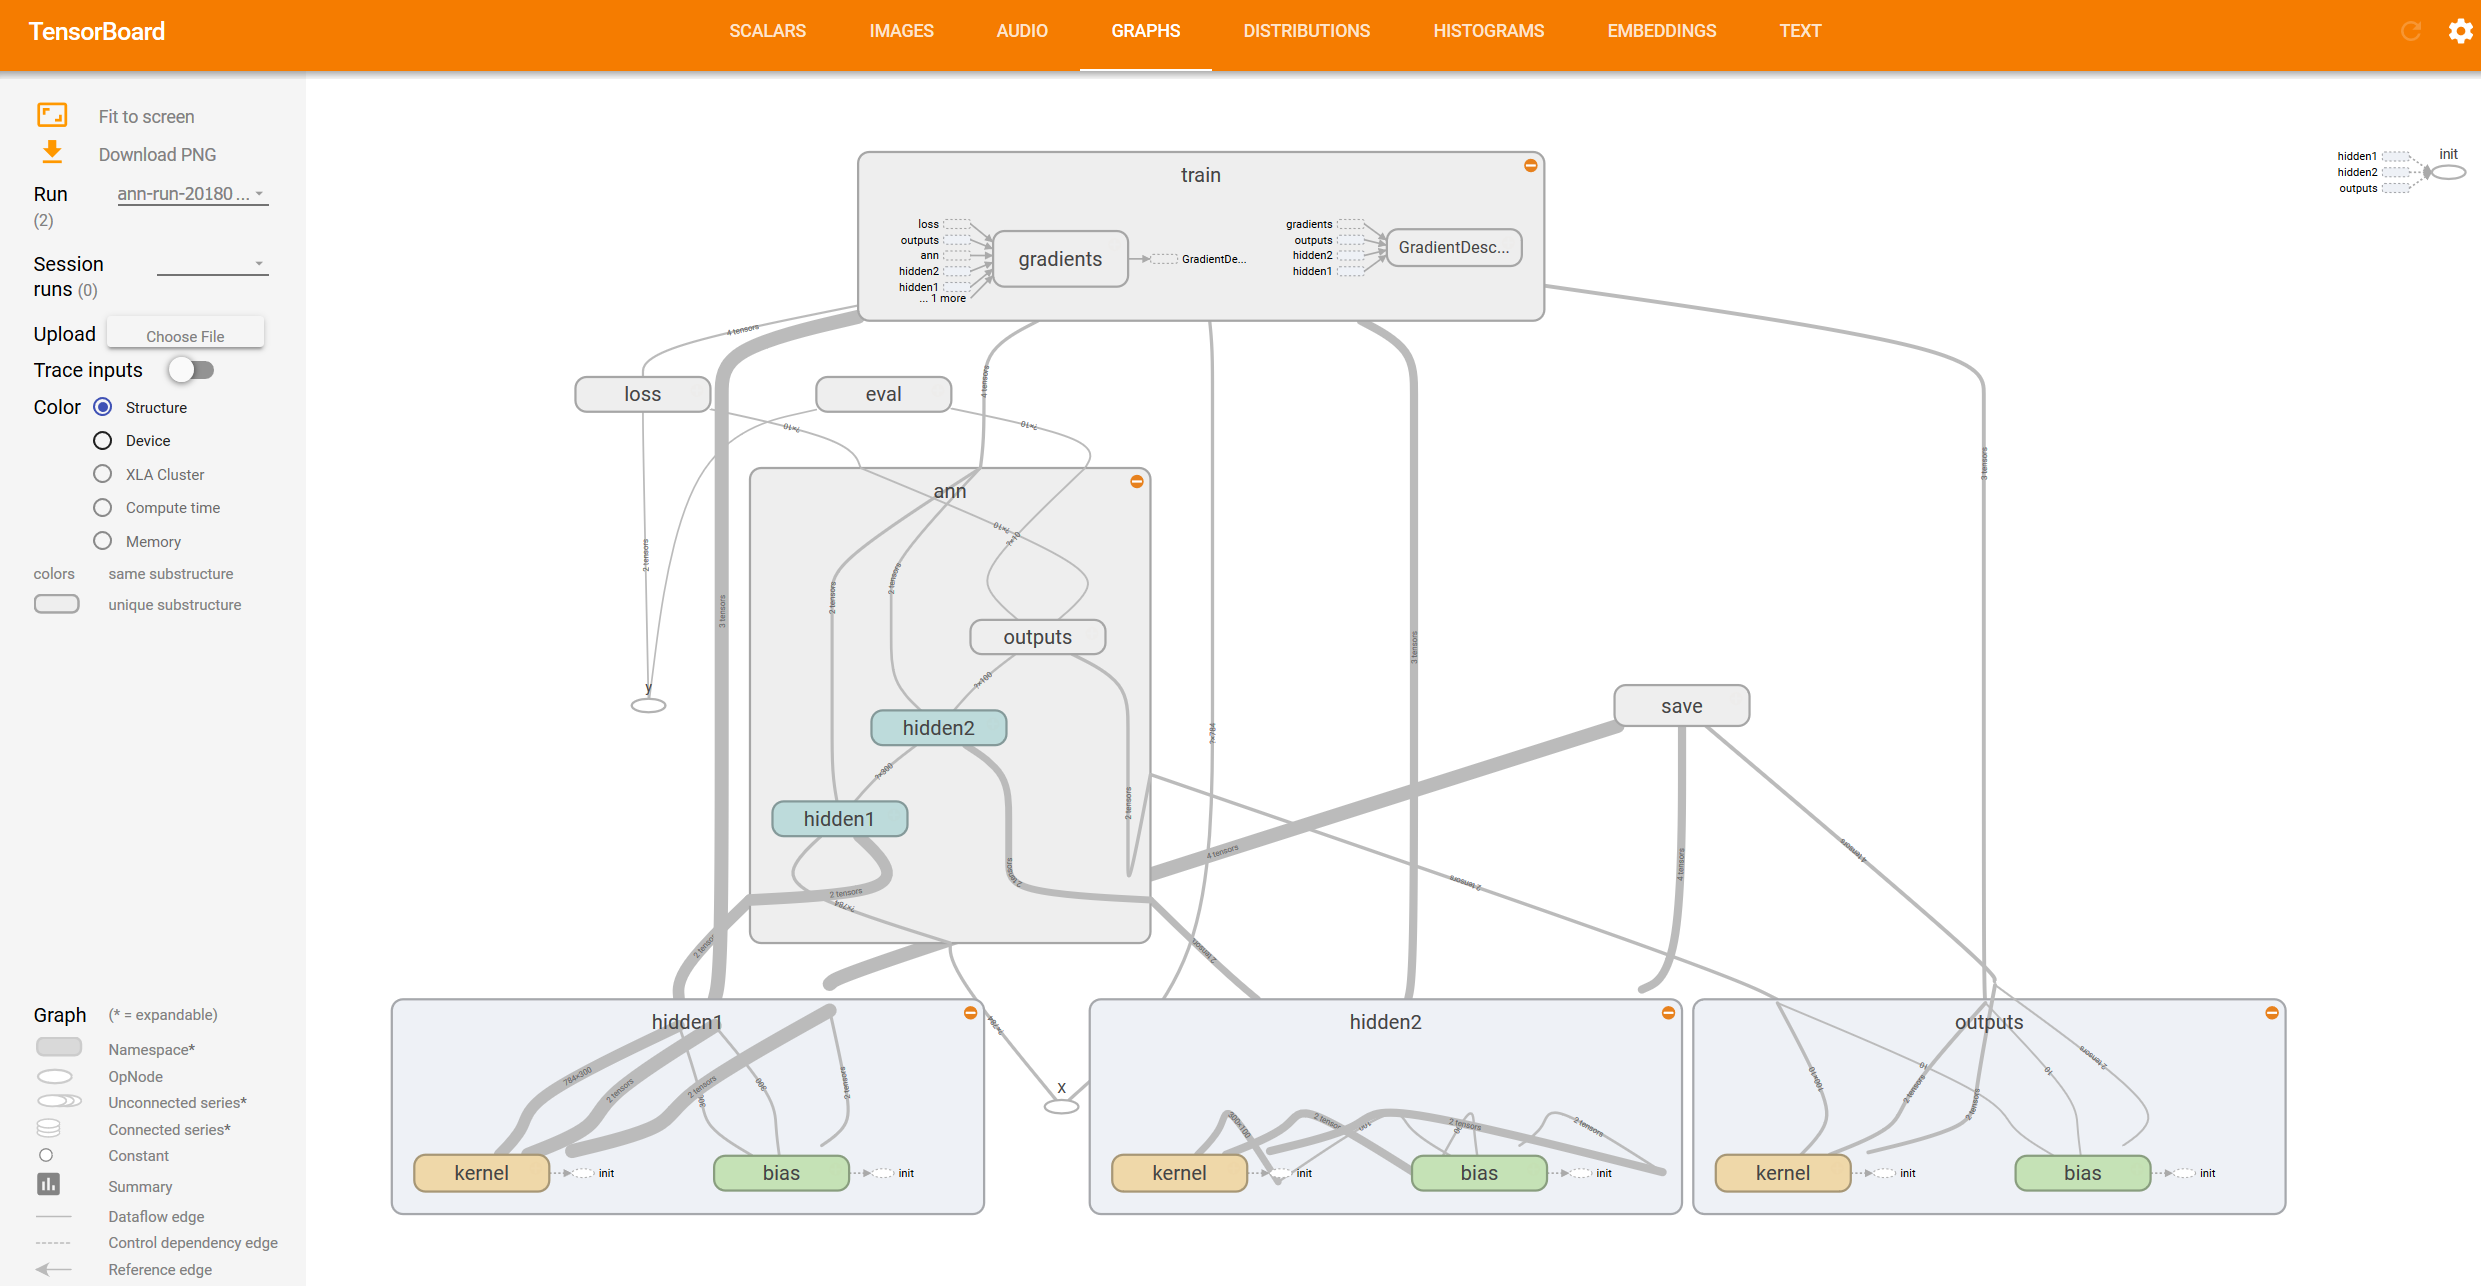